In [23]:
import torch
from torch.backends import cudnn
from torch import nn
import torchvision  # 图片、视频处理
from torchvision.transforms import ToTensor
import torch.nn.functional as F  # 避免relu和sigmoid的初始化，可以直接调用

from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split    

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math, random
# %matplotlib inline
# vTest = 1000

from importlib import reload 
from qflib import basic
reload(basic)
global engine, conn
engine = basic.engine()
conn = basic.conn(engine)

device = 'cuda' if torch.cuda.is_available else 'cpu'
device = 'cpu'
torch.__version__, torchvision.__version__, device


('2.0.1', '0.15.2', 'cpu')

ToTensor: 
- 1、输入转为Tensor，
- 2、图片格式为 channel, height, width; 
- 3、像素取值范围规范到0/1

torch.utils.data.DataLoader, 作用：
- 乱序， shuffle 默认为 True
- 将数据采样为小批次， batch_size. batch太小会导致loss的剧烈震荡，太大则内存放不下，也会跨度过大，失去准确性；
- num_workers, 子进程设置，更多进程参与
- 设置批次处理函数 collate_fn, 用在文本等


In [24]:
# 读取数据 
sql="SELECT * FROM ds_qf60"
df = pd.read_sql_query(sql, conn, index_col=None)
del df['index']
len(df), 
# df.head(1)

(52207,)

In [25]:
""" 确定训练的目标 """
df['class0'] = df['sz_jt_10']  # 10天内的阶梯涨幅
# 查看 class0 是否准确、百分比
df.class0.unique(), df.class0.value_counts(), df.class0.value_counts()/len(df)

(array([0, 1, 2], dtype=int64),
 0    33904
 1    12885
 2     5418
 Name: class0, dtype: int64,
 0    0.649415
 1    0.246806
 2    0.103779
 Name: class0, dtype: float64)

In [26]:
#  'diff', 'dea',, 
# X_columns0 = ['pct_change', 
#              'jx_days_ud60', 
#              'jx_xl_120','jx_xl_60', 'jx_xl_20', 
#              'jx_zs_20', 
#              'lj_fl_5_20','lj_fl_20_60']
X_columns = ['jx_dg_5', 'jx_dg_10',\
             'pct_fl_1_3','pct_fl_3_10','pct_fl_5_20']
df[ X_columns ]

,jx_dg_5,jx_dg_10,pct_fl_1_3,pct_fl_3_10,pct_fl_5_20
0,19.34290,12.678300,1.72046,1.41063,1.025250
1,42.33150,15.256600,1.18279,1.83067,1.672700
2,6.51617,0.465063,1.27158,1.60911,1.149490
3,-1.86388,1.395300,1.34096,1.34546,0.958903
4,61.55660,11.600200,1.42675,1.57184,1.303950
...,...,...,...,...,...
52202,101.61400,94.359200,1.49608,1.11988,1.802570
52203,86.52510,16.639000,2.98854,2.45102,2.602640
52204,124.96500,74.583900,2.28043,1.25808,0.954236
52205,50.90050,4.548050,2.74237,1.21222,0.777479


In [27]:
X_data = df[X_columns]  
X = torch.from_numpy(X_data.values).type(torch.float32)
# Y_data = df.class0.values.reshape(-1,0)  # 转换成 pd type array
Y_data = df.class0.values  # 转换成 pd type array
Y = torch.from_numpy(Y_data).long()
# Y = torch.from_numpy(Y_data).type(torch.float32)
# X_data.shape, X_data.head(3)
X.shape, Y.shape

(torch.Size([52207, 5]), torch.Size([52207]))

In [28]:
# 最后检测Y_data数据准确性
unique, counts = np.unique(Y_data, return_counts=True)
unique, counts


(array([0, 1, 2], dtype=int64), array([33904, 12885,  5418], dtype=int64))

In [29]:
# X,Y 形成main dataset, train/test dataset 
X, Y = X.to(device), Y.to(device)
main_dataset = TensorDataset(X, Y)
train_ds, test_ds = random_split(main_dataset, [0.8, 0.2]) 

In [30]:
# batch_size = 4
# # batch_size = 16
# # batch_size = 64
# # batch_size = 4096
# train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)  # batch_size开始为64,可能是最佳，或128
# test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [31]:
# imgs, labels = next(iter(train_dl))   # train dataloder 可以分解出X和Ydata
# imgs.shape, labels.shape   # 1: 黑白图片， 28x28的图片分辨率， 64张


In [32]:
# imgs[0].shape, imgs[0, 0, 0]
# imgs

In [33]:
# labels

In [34]:
# 各种激活函数测试
# f(x) = max(x, 0)
# input = torch.randint(2,[2,3,4])
# input = torch.randn(5)
# input
# input, torch.relu(input)

# input,torch.sigmoid( input )
# input,torch.tanh( input )
# input,nn.LeakyReLU( input )

上面是数据准备和模式测试， 
以下正式开始设计：

In [35]:
# 多层感知器模型， 添加1个隐藏层，
class Model3( nn.Module ):   # 从nn类初始化
    def __init__(self):
        super(Model3, self).__init__()  # 初始化父类属性
        self.linear_1 = nn.Linear(5, 120)  # 全连接层、线性层，； 要求输入数据是1维的，所以[1, 28, 28]被压缩到1层28*28；view()
        self.bn_f1 = nn.BatchNorm1d(120)
        self.drop = nn.Dropout(0.5)             # 0.5, 丢掉50% 神经单元
        self.linear_2 = nn.Linear(120, 84)  # 线性层， 
        self.bn_f2 = nn.BatchNorm1d(84)
        self.linear_3 = nn.Linear(84, 3)  # 线性层， 

    def forward(self, input):
        x = input.view(-1, 5)
        x = torch.relu(self.linear_1(x))
        x = self.bn_f1(x)
        x = self.drop(x)
        x = torch.relu(self.linear_2(x))
        x = self.bn_f2(x)
        x = self.drop(x)
        logits = self.linear_3(x)            # 第3层不做激活函数， 算出在10个分量上，可能值最大的分量，就定义为分量的标签值。即哪个标签分量值最大，就是那个数字。
        return logits                         # logits: 一般指未激活前的输出2

class Model4( nn.Module ):   # 从nn类初始化
    def __init__(self):
        super(Model4, self).__init__()  # 初始化父类属性
        self.linear_1 = nn.Linear(5, 64)  # 全连接层、线性层，； 要求输入数据是1维的，所以[1, 28, 28]被压缩到1层28*28；view()
        self.bn_f1 = nn.BatchNorm1d(64)
        self.drop = nn.Dropout(0.5)             # 0.5, 丢掉50% 神经单元
        self.linear_2 = nn.Linear(64, 64)  # 线性层， 
        self.bn_f2 = nn.BatchNorm1d(64)
        self.linear_3 = nn.Linear(64, 64)  # 线性层， 
        self.bn_f3 = nn.BatchNorm1d(64)
        self.linear_4 = nn.Linear(64, 3)  # 线性层， 

    def forward(self, input):
        x = input.view(-1, 5)
        x = self.linear_1(x)
        x = self.bn_f1(x)
        x = torch.relu(x)
        x = self.drop(x)
        x = self.linear_2(x)
        x = self.bn_f2(x)
        x = torch.relu(x)
        x = self.drop(x)
        x = self.linear_3(x)
        x = self.bn_f3(x)
        x = torch.relu(x)
        x = self.drop(x)
        logits = self.linear_4(x)            # 第3层不做激活函数， 算出在10个分量上，可能值最大的分量，就定义为分量的标签值。即哪个标签分量值最大，就是那个数字。
        return logits                         # logits: 一般指未激活前的输出2
    
class Model5( nn.Module ):   # 从nn类初始化
    def __init__(self):
        super(Model5, self).__init__()  # 初始化父类属性
        self.linear_1 = nn.Linear(6, 256)  # 全连接层、线性层，； 要求输入数据是1维的，所以[1, 28, 28]被压缩到1层28*28；view()
        self.bn_f1 = nn.BatchNorm1d(256)
        self.drop = nn.Dropout(0.5)             # 0.5, 丢掉50% 神经单元
        self.linear_2 = nn.Linear(256, 256)  # 线性层， 
        self.bn_f2 = nn.BatchNorm1d(256)
        self.linear_3 = nn.Linear(256, 128)  # 线性层， 
        self.bn_f3 = nn.BatchNorm1d(128)
        self.linear_4 = nn.Linear(128, 64)  # 线性层， 
        self.bn_f4 = nn.BatchNorm1d(64)
        self.linear_5 = nn.Linear(64, 4)  # 线性层， 

    def forward(self, input):
        x = input.view(-1, 6)
        x = torch.relu(self.linear_1(x))
        x = self.bn_f1(x)
        x = self.drop(x)
        x = torch.relu(self.linear_2(x))
        x = self.bn_f2(x)
        x = self.drop(x)
        x = torch.relu(self.linear_3(x))
        x = self.bn_f3(x)
        x = self.drop(x)
        x = torch.relu(self.linear_4(x))
        x = self.bn_f4(x)
        x = self.drop(x)
        logits = self.linear_5(x)            # 第3层不做激活函数， 算出在10个分量上，可能值最大的分量，就定义为分量的标签值。即哪个标签分量值最大，就是那个数字。
        return logits                         # logits: 一般指未激活前的输出2


In [36]:
model = Model4()
model = model.to(device)  
model

Model4(
  (linear_1): Linear(in_features=5, out_features=64, bias=True)
  (bn_f1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (linear_2): Linear(in_features=64, out_features=64, bias=True)
  (bn_f2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_3): Linear(in_features=64, out_features=64, bias=True)
  (bn_f3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_4): Linear(in_features=64, out_features=3, bias=True)
)

In [37]:
"""
- target： 0,1,2,3.。。 并不是一个独热编码的形式？
- input： logits
- output：？
"""
loss_fn = nn.CrossEntropyLoss()  
# loss_fn = nn.NLLLoss()  
# input = torch.randn(5)
# input, np.argmax(input)

In [38]:
"""
优化： 根据计算得到的损失，调整模型参数， 降低损失的过程；
- Adam 优化器
- SGD：优化model的参数、以及lr
"""
opt = torch.optim.SGD(model.parameters(), lr=0.001)

In [39]:
"""
训练循环：计算准确率correect， 以及每个批次的平均loss
"""
def train(dl, model, loss_fn, optimizer):
    size = len( dl.dataset )    # 数据多少？
    num_batches = len(dl)       # 返回训练批次
    train_loss, correct = 0, 0 # 每个批次累计的loss之和， 正确的样本数累计
    model.train()   #设置成训练模式
    for x, y in dl:
        # x, y = x.to(device), y.to(device)
        pred = model(x)
        # pred = pred.to(torch.FloatTensor)
        loss = loss_fn(pred, y)     # 按照损失函数，计算损失
        optimizer.zero_grad()       # 清零后计算新的loop的梯度；
        loss.backward()             # 按照loss，反向计算梯度；
        optimizer.step()
        with torch.no_grad():
            # pred是2维，0维是batch数，1维才是0-9的logits输出；boll转换为float32，累计;item转换到python
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()  
            train_loss += loss.item()
    correct /= size
    train_loss /= num_batches      # losss是以每个批次计算，correct是以个数计算；所以分母不同；
    return correct, train_loss

In [40]:
# pred = model(x)

In [41]:
# 测试函数: 计算准确率correect， 以及每个批次的平均loss
def test(test_dl, model, loss_fn):
    size = len( test_dl.dataset )    # 数据多少？
    num_batches = len(test_dl)       # 返回训练批次
    test_loss, correct = 0, 0 # 每个批次累计的loss之和， 正确的样本数累计
    model.eval()  # 设置成eval 评估测试模式， 推理模式
    with torch.no_grad():
        for x, y in test_dl:
            # x, y = x.to(device), y.to(device)
            pred = model(x)
            # pred = pred.to(torch.FloatTensor)
            loss = loss_fn(pred, y)     # 按照损失函数，计算损失
            test_loss += loss.item()
            # pred是2维，0维是batch数，1维才是0-9的logits输出；boll转换为float32，累计;item转换到python
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()  
        correct /= size
        test_loss /= num_batches      # losss是以每个批次计算，correct是以个数计算；所以分母不同；
        return correct, test_loss

In [42]:
""" 
    训练 N 个 epoch， 记录每个epoch的train和test的损失、准确率。 
"""
# batch_size 非常关键：4096不准确； 64很准确。16也比较差。 ！！！
def fit(epochs, train_dl, test_dl, model, loss_fn, opt ):
    # epochs = 20
    train_loss, train_acc = [], []
    test_loss,  test_acc  = [], []

    for epoch in range( epochs ):
        epoch_acc, epoch_loss = train( train_dl, model, loss_fn, opt)
        epoch_test_acc, epoch_test_loss = test( test_dl, model, loss_fn)
        train_acc.append(epoch_acc)
        train_loss.append(epoch_loss)
        test_acc.append(epoch_test_acc)
        test_loss.append(epoch_test_loss)  # 记录、图表化后，观察是否会过拟合等问题
        
        template = ("epoch:{:2d}, train_Loss:{:.5f}, train_acc:{:.2f}, test_Loss:{:.5f}, test_acc:{:.2f}, ")
        print(template.format( epoch, epoch_loss, epoch_acc*100, epoch_test_loss, epoch_test_acc*100))
    print('Done')
    return train_loss, train_acc, test_loss, test_acc


In [44]:
batch_size = 2
# batch_size = 4
# batch_size = 8
# batch_size = 16
# batch_size = 64   
# batch_size = 128
epochs = 20
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)  # batch_size开始为64
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)
train_loss, train_acc, test_loss, test_acc = fit(epochs,train_dl, test_dl, model, loss_fn, opt)

epoch: 0, train_Loss:0.87776, train_acc:64.49, test_Loss:0.91854, test_acc:65.08, 
epoch: 1, train_Loss:0.87023, train_acc:64.91, test_Loss:0.89138, test_acc:65.08, 
epoch: 2, train_Loss:0.86792, train_acc:64.91, test_Loss:0.88212, test_acc:65.08, 
epoch: 3, train_Loss:0.86703, train_acc:64.91, test_Loss:0.87689, test_acc:65.08, 
epoch: 4, train_Loss:0.86631, train_acc:64.91, test_Loss:0.87390, test_acc:65.08, 
epoch: 5, train_Loss:0.86656, train_acc:64.91, test_Loss:0.86860, test_acc:65.08, 
epoch: 6, train_Loss:0.86595, train_acc:64.91, test_Loss:0.86540, test_acc:65.08, 
epoch: 7, train_Loss:0.86621, train_acc:64.91, test_Loss:0.85942, test_acc:65.08, 
epoch: 8, train_Loss:0.86592, train_acc:64.91, test_Loss:0.86208, test_acc:65.08, 
epoch: 9, train_Loss:0.86520, train_acc:64.91, test_Loss:0.85903, test_acc:65.08, 
epoch:10, train_Loss:0.86551, train_acc:64.91, test_Loss:0.85939, test_acc:65.08, 
epoch:11, train_Loss:0.86502, train_acc:64.91, test_Loss:0.85897, test_acc:65.08, 
epoc

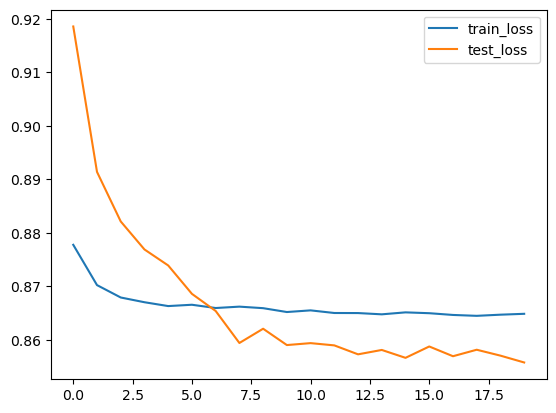

In [45]:
plt.plot( range(epochs), train_loss, label='train_loss')
plt.plot( range(epochs), test_loss, label='test_loss')
plt.legend()

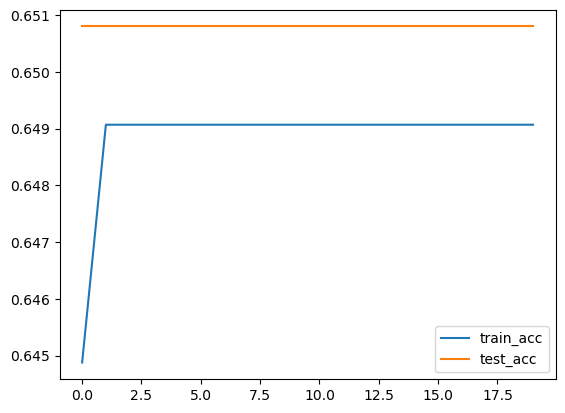

In [46]:
plt.plot( range(epochs), train_acc, label='train_acc')
plt.plot( range(epochs), test_acc, label='test_acc')
plt.legend()